# Hidden Regimes in Correlation Space
### Premise:
Rather than price or volatility, correlation structure between assets defines market regimes. When average pairwise correlations spike, markets enter “systemic” regimes. We are trying to predict if regime changes influence volatility clustering or crashes.

### Hypothesis:
Market regimes are better identified by cross-sectional correlation structure than by single time-series levels; when average pairwise correlations and network centrality spike, the market is in a “systemic” regime that precedes volatility clustering and large drawdowns.

### Research Question:
Can we detect latent market regimes by clustering the time-varying correlation structure across major sectors/assets, and do transitions to a “high-correlation” regime predict subsequent volatility spikes or market crashes?

### Simple Alternatives:
Does this approach beat just watching VIX or simple correlation metrics?

## Clean and Collect Data
Assets
- Broad equities: (SPY)
- Sector ETFs: XLK (Tech), XLF (Financials), XLE (Energy), XLY (Consumer Discretionary), XLP (Staples), XLI (Industrials), XLV (Health), XLU (Utilities), XLB (Materials), IWM (Russell 2000)
- Other asset classes: TLT (long Treasuries), HYG (high yield), GLD (gold), USO (oil), BTC-USD (crypto)

Data:
- yfinance for ETF prices
- FRED for macros

Frequency:
- daily close prices

Time Span:
- past 10 years to include crises of past regime transitions (2015, 2018, 2020, 2022)

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import networkx as nx

print("Libraries installed.")

Libraries installed.


In [22]:
FRED_API_KEY = "f124dd8cecaa3c98064f3736e29c1ba8"
fred = Fred(api_key=FRED_API_KEY)

start_date = "2013-01-01"
end_date = date.today().isoformat()
np.random.seed(0)

### Fetch ETF Price Data
We'll download daily adjusted close prices for a broad market ETF and sector ETFs.

In [23]:
etf_tickers = [
    "SPY",  # broad market
    "XLK", "XLF", "XLE", "XLY", "XLP", "XLI", "XLV", "XLU", "XLB", "IWM"
]

etf_data = yf.download(etf_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)['Close']
etf_data = etf_data.asfreq('B').ffill().bfill().dropna(how='any')

print("ETF data shape:", etf_data.shape)
etf_data.tail()

ETF data shape: (3338, 11)


Ticker,IWM,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,
2025-10-13,244.410004,663.039978,88.230003,86.379997,52.660000,151.460007,285.170013,77.839996,90.889999,141.949997,233.860001
2025-10-14,247.899994,662.229980,89.110001,86.370003,53.240002,153.240005,281.510010,79.089996,91.699997,142.339996,234.350006
2025-10-15,250.330002,665.169983,88.709999,86.320000,53.240002,152.600006,284.299988,79.230003,92.900002,142.559998,234.690002
2025-10-16,245.059998,660.640015,88.050003,85.279999,51.759998,151.600006,284.510010,78.680000,91.889999,142.320007,232.419998
2025-10-17,243.410004,664.390015,87.879997,85.980003,52.180000,151.729996,285.010010,79.730003,91.570000,143.270004,234.419998


### Compute Log Returns
Convert price series to log returns using: 
\[
r_t = \ln \left( \frac{P_t}{P_{t-1}} \right)
\]


In [24]:
etf_returns = np.log(etf_data / etf_data.shift(1)).dropna()
etf_returns.tail()

Ticker,IWM,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,
2025-10-13,0.027459,0.015228,0.015765,0.013520,0.009540,0.010353,0.024062,-0.003335,0.007621,-0.001127,0.022093
2025-10-14,0.014178,-0.001222,0.009924,-0.000116,0.010954,0.011684,-0.012918,0.015931,0.008872,0.002744,0.002093
2025-10-15,0.009755,0.004430,-0.004499,-0.000579,0.000000,-0.004185,0.009862,0.001769,0.013001,0.001544,0.001450
2025-10-16,-0.021277,-0.006834,-0.007468,-0.012121,-0.028192,-0.006575,0.000738,-0.006966,-0.010931,-0.001685,-0.009719
2025-10-17,-0.006756,0.005660,-0.001933,0.008175,0.008082,0.000857,0.001756,0.013257,-0.003488,0.006653,0.008568


### Fetch and Prepare Macroeconomic Data
We'll pull key macro indicators from FRED. Then, we'll resample to business days and fill missing values.

In [25]:
macro_series = {
    "DGS10": "10Y_Treasury_Yield",
    "FEDFUNDS": "Fed_Funds_Rate",
    "CPIAUCSL": "CPI",
    "INDPRO": "Industrial_Production",
    "UNRATE": "Unemployment_Rate"
}

macro_data = pd.DataFrame()

for series_id, label in macro_series.items():
    s = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    macro_data[label] = s

macro_data = macro_data.resample('B').ffill().bfill()

# drop rows with too many missing values
macro_data = macro_data.dropna(thresh=int(0.7 * macro_data.shape[1]))

print("Macro data shape:", macro_data.shape)
macro_data.tail()

Macro data shape: (3284, 5)


,10Y_Treasury_Yield,Fed_Funds_Rate,CPI,Industrial_Production,Unemployment_Rate
2025-07-28,4.42,4.33,323.364,103.9203,4.3
2025-07-29,4.34,4.33,323.364,103.9203,4.3
2025-07-30,4.38,4.33,323.364,103.9203,4.3
2025-07-31,4.37,4.33,323.364,103.9203,4.3
2025-08-01,4.23,4.33,323.364,103.9203,4.3


### Merge ETF Returns with Macro Data

In [26]:
merged_df = etf_returns.merge(macro_data, left_index=True, right_index=True, how="left")
merged_df = merged_df.ffill()

print("ETF returns shape:", etf_returns.shape)
print("Macro data shape:", macro_data.shape)
print("Merged dataset shape:", merged_df.shape)
merged_df.tail()

ETF returns shape: (3337, 11)
Macro data shape: (3284, 5)
Merged dataset shape: (3337, 16)


,IWM,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,10Y_Treasury_Yield,Fed_Funds_Rate,CPI,Industrial_Production,Unemployment_Rate
Date,,,,,,,,,,,,,,,,
2025-10-13,0.027459,0.015228,0.015765,0.013520,0.009540,0.010353,0.024062,-0.003335,0.007621,-0.001127,0.022093,4.23,4.33,323.364,103.9203,4.3
2025-10-14,0.014178,-0.001222,0.009924,-0.000116,0.010954,0.011684,-0.012918,0.015931,0.008872,0.002744,0.002093,4.23,4.33,323.364,103.9203,4.3
2025-10-15,0.009755,0.004430,-0.004499,-0.000579,0.000000,-0.004185,0.009862,0.001769,0.013001,0.001544,0.001450,4.23,4.33,323.364,103.9203,4.3
2025-10-16,-0.021277,-0.006834,-0.007468,-0.012121,-0.028192,-0.006575,0.000738,-0.006966,-0.010931,-0.001685,-0.009719,4.23,4.33,323.364,103.9203,4.3
2025-10-17,-0.006756,0.005660,-0.001933,0.008175,0.008082,0.000857,0.001756,0.013257,-0.003488,0.006653,0.008568,4.23,4.33,323.364,103.9203,4.3


### Feature engineering: rolling correlation matrices & summary stats

We want a time series of correlation-structure features that feed the HMM.

**Rolling Window Setup:**
- Window length \( W = 60 \) trading days (≈ 3 months)
- Step size = 1 day

**Features extracted:**
- `avg_corr`: mean of off-diagonal correlations  
- `corr_std`: std of off-diagonal correlations  
- `top_eig`, `eig_gap`: eigenvalue structure  
- `max_node_strength`, `mean_node_strength`: graph-based strength metrics  
- `mean_centrality`, `max_centrality`: network centrality features

In [27]:
def compute_corr_features(window_returns):
    lw = LedoitWolf().fit(window_returns)
    C = lw.covariance_
    corr = C / np.outer(np.sqrt(np.diag(C)), np.sqrt(np.diag(C)))
    eigvals = np.sort(np.linalg.eigvalsh(corr))[::-1]
    off_diag = corr[np.triu_indices_from(corr, k=1)]
    G = nx.from_numpy_array(np.abs(corr))
    centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
    centrality_vals = np.array(list(centrality.values()))
    node_strengths = np.sum(np.abs(corr), axis=1)
    return {
        'avg_corr': np.mean(off_diag),
        'corr_std': np.std(off_diag),
        'top_eig': eigvals[0],
        'eig_gap': eigvals[0] - eigvals[1],
        'max_node_strength': node_strengths.max(),
        'mean_node_strength': node_strengths.mean(),
        'mean_centrality': centrality_vals.mean(),
        'max_centrality': centrality_vals.max()
    }

In [28]:
W = 60  # window length
feature_list = []
dates = etf_returns.index

for i in range(W, len(dates)):
    feats = compute_corr_features(etf_returns.iloc[i-W:i])
    feats['date'] = dates[i]
    feature_list.append(feats)

features_df = pd.DataFrame(feature_list).set_index('date')
print("Correlation features shape:", features_df.shape)
features_df.head()

Correlation features shape: (3277, 8)


,avg_corr,corr_std,top_eig,eig_gap,max_node_strength,mean_node_strength,mean_centrality,max_centrality
date,,,,,,,,
2013-03-28,0.648326,0.106821,7.547930,6.851439,8.508220,7.483264,0.300126,0.341975
2013-03-29,0.644303,0.108486,7.509780,6.788506,8.471092,7.443032,0.300070,0.342351
2013-04-01,0.646665,0.106560,7.530914,6.804634,8.487622,7.466653,0.300128,0.342073
2013-04-02,0.649383,0.105482,7.555729,6.839758,8.515379,7.493828,0.300186,0.341959
2013-04-03,0.632935,0.109415,7.392980,6.581923,8.395033,7.329353,0.300112,0.344636


### Macro Transformations
We'll engineer simple macro-based features to capture momentum or change.

In [29]:
macro_diff = macro_data.copy()

macro_diff['CPI_YoY'] = macro_diff['CPI'].pct_change(252)
macro_diff['INDPRO_MoM'] = macro_diff['Industrial_Production'].pct_change(21)
macro_diff['UNRATE_Change'] = macro_diff['Unemployment_Rate'].diff(21)

macro_diff = macro_diff.ffill().bfill()

print("Macro diff shape:", macro_diff.shape)
macro_diff.tail()

Macro diff shape: (3284, 8)


,10Y_Treasury_Yield,Fed_Funds_Rate,CPI,Industrial_Production,Unemployment_Rate,CPI_YoY,INDPRO_MoM,UNRATE_Change
2025-07-28,4.42,4.33,323.364,103.9203,4.3,0.024718,0.000972,0.1
2025-07-29,4.34,4.33,323.364,103.9203,4.3,0.024718,0.000972,0.1
2025-07-30,4.38,4.33,323.364,103.9203,4.3,0.024718,0.000972,0.1
2025-07-31,4.37,4.33,323.364,103.9203,4.3,0.024718,0.000000,0.0
2025-08-01,4.23,4.33,323.364,103.9203,4.3,0.024718,0.000000,0.0


### Feature Integration and Standardization

In [ ]:
final_df = features_df.merge(macro_diff, left_index=True, right_index=True, how='left')
final_df = final_df.ffill().bfill()

# Standardize features for HMM or clustering models
scaler = StandardScaler()
scaled_array = scaler.fit_transform(final_df)
scaled_df = pd.DataFrame(scaled_array, index=final_df.index, columns=final_df.columns)

print("Final feature matrix shape:", scaled_df.shape)
scaled_df.tail()

✅ Final feature matrix shape: (3277, 16)


,avg_corr,corr_std,top_eig,eig_gap,max_node_strength,mean_node_strength,mean_centrality,max_centrality,10Y_Treasury_Yield,Fed_Funds_Rate,CPI,Industrial_Production,Unemployment_Rate,CPI_YoY,INDPRO_MoM,UNRATE_Change
date,,,,,,,,,,,,,,,,
2025-10-13,-1.585315,0.458894,-1.571367,-1.381892,-1.639098,-1.628230,-2.140532,1.989413,1.545641,1.358714,1.891032,0.9233,-0.363393,-0.066344,-0.028344,0.022001
2025-10-14,-1.476782,0.665809,-1.424980,-1.270190,-1.482402,-1.504491,-2.171850,1.872905,1.545641,1.358714,1.891032,0.9233,-0.363393,-0.066344,-0.028344,0.022001
2025-10-15,-1.502416,0.627288,-1.454385,-1.277585,-1.489302,-1.530353,-2.162220,1.937102,1.545641,1.358714,1.891032,0.9233,-0.363393,-0.066344,-0.028344,0.022001
2025-10-16,-1.527196,0.565409,-1.494025,-1.316727,-1.530991,-1.556981,-2.097805,1.941946,1.545641,1.358714,1.891032,0.9233,-0.363393,-0.066344,-0.028344,0.022001
2025-10-17,-1.449778,0.526408,-1.430503,-1.267092,-1.410692,-1.485788,-1.890306,1.960163,1.545641,1.358714,1.891032,0.9233,-0.363393,-0.066344,-0.028344,0.022001


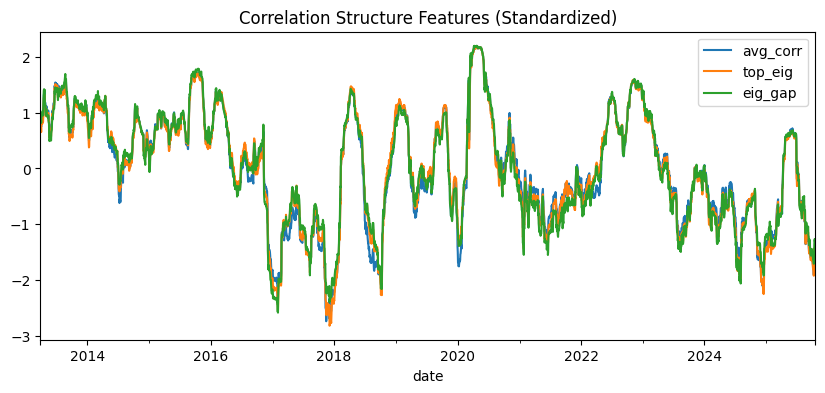

In [31]:
scaled_df[['avg_corr', 'top_eig', 'eig_gap']].plot(title="Correlation Structure Features (Standardized)", figsize=(10,4))
plt.show()